# 強制力と摩擦力下における速度変化のアジョイントコード

## ----------コードを書く前の下準備-----------

### Reference

- 淡路敏之・蒲地政文・池田元美・石川洋一，データ同化ー観測・実験とモデルを融合するイノベーションー，京都大学学術出版会，2009．
- 藤井陽介・碓氷典久・丹羽洋介，変分法データ同化と正定値対称行列，2014，http://www3.grips.ac.jp/~tsuchiya/PSD/slides/fujii140115.pdf

### 微分方程式モデル

次の微分方程式モデルを考える
\begin{align}
\frac{du}{dt}=w_t^x-f\sqrt{u_t^2+v_t^2}u_t\\
\frac{dv}{dt}=w_t^y-f\sqrt{u_t^2+v_t^2}v_t
\end{align}
ここで，$u,v$は速度の$x,y$成分，$w_t^x,w_t^y$は強制力の$x,y$成分，$f$は摩擦係数を表す

$V=\sqrt{u^2+v^2}$とし，オイラーの前進差分を適用すると，
\begin{gather}
V_t=\sqrt{u_t^2+v_t^2}\\
u_{t+1}=u_t+\Delta t(w_t^x+fV_tu_t)\\
v_{t+1}=v_t+\Delta t(w_t^y+fV_tv_t)
\end{gather}
となる．

### 接線形演算子とアジョイント演算子

$V,u,v$の変分を計算すると，
\begin{gather}
\delta V\leftarrow \frac{u_t}{V_t}\delta u+\frac{v_t}{V_t}\delta v\\
\delta u\leftarrow \delta u-\Delta t\ f(\delta V\ u_t+V_t\ \delta u)\\
\delta v\leftarrow \delta v-\Delta t\ f(\delta V\ v_t+V_t\ \delta v)
\end{gather}
となる．それぞれ行列で表せば，
\begin{gather}
F_1=\left(\begin{array}{ccc}1&0&0\\0&1&0\\u_t/V_t&v_t/V_t&0\end{array}\right),\ 
F_2=\left(\begin{array}{ccc}1-\Delta t\ f\ V_t&0&-\Delta t\ f\ u_t\\0&1&0\\0&0&1\end{array}\right),\ 
F_3=\left(\begin{array}{ccc}1&0&0\\0&1-\Delta t\ f\ V_t&-\Delta t\ f\ v_t\\0&0&1\end{array}\right)
\end{gather}
となるので，$M=F_3F_2F_1$が接線形演算子である．また，転置をとれば，
\begin{gather}
F_1^T=\left(\begin{array}{ccc}1&0&u_t/V_t\\0&1&v_t/V_t\\0&0&0\end{array}\right),\ 
F_2^T=\left(\begin{array}{ccc}1-\Delta t\ f\ V_t&0&0\\0&1&0\\-\Delta t\ f\ u_t&0&1\end{array}\right),\ 
F_3^T=\left(\begin{array}{ccc}1&0&0\\0&1-\Delta t\ f\ V_t&0\\0&-\Delta t\ f\ v_t&1\end{array}\right)
\end{gather}
となることから，アジョイント演算子は$A=F_1^TF_2^TF_3^T$とすればよい．

### アジョイント法

評価関数が
\\[J=\frac{1}{2}(x_0-x^b)^TB^{-1}(x_0-x^b)+\frac{1}{2}\sum_{t=0}^T(H_t(x_t)-y_t)^TR_t^{-1}(H_t(x_t)-y_t)\\]
のとき，アジョイント法による逆伝播は次の様な式で表せた．
\begin{align}
&\lambda_{T+1}=0\\
&\lambda_t = \mathbf{M}_t^T\lambda_{t+1}+\mathbf{H}_t^TR_t^{-1}(H_t(x_t)-y_t)\\
&\lambda_0=\mathbf{M}_0^T\lambda_1+B^{-1}(x_0-x^b)+\mathbf{H}_0^TR_0^{-1}(H_0(x_0)-y_0)=g
\end{align}
であった．ここで，$x^b$は背景値（決定論的シミュレーション値，大雑把な見積もり），$B$は背景誤差共分散行列（背景値と解析値との誤差の共分散行列，$x_0\sim N(x^b,B)$），$H_t$は観測演算子，$\mathbf{H}_t$は観測接線形演算子（観測演算子のヤコビアン），$y_t$は観測値，$R_t$は観測誤差共分散行列（解析値と観測値との誤差の共分散行列$y_t\sim N(H_t(x_t),R_t)$），$\lambda_t$はアジョイント演算子（データミスフィットを伝播する役割），$g$は評価関数の勾配である．

以下，コード上では，観測演算子$H_t$は単位行列，すなわち，$H_t(x_t)=x_t,\mathbf{H}_t=I_3$として議論を進める．

## ----------コード作成----------

ディレクトリ構造について
- DataAssimilation > try_and_error > Python_source : saving place for source
- DataAssimilation > try_and_error > plot : saving place for plot result

バージョンについて
- Mac OS 10.10
- Python 3.6.1
- numpy 1.12.1
- pandas 0.20.1
- matplotlib 2.0.2
- seaborn 0.7.1

In [1]:
import math
import numpy as np
import numpy.random as rd
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

### 決定論的シミュレーション値と観測値の計算コード

In [43]:
# Euler forward differential
def Euler_forward_differential (state, forcing_wx, forcing_wy, f, dt, t) :
    '''
    <Input Variables>
    state [n_dim] {float} : velocity and speed (u, v, V)
    forcing_wx {function} : x element of forcing function (t)
    forcing_wy {function} : y element of forcing function (t)
    f {float} : coefficient of friction
    dt {float} : time interval of differential equation
    t {int} : time
    
    <Variables>
    u {float} : x element of velocity
    v {float} : y element of velocity
    V {float} : speed, which means sqrt(u**2 + v**2)
    new_state [n_dim] {float} : updated state (u, v, V)
    '''
    u = state[0]
    v = state[1]
    #V = state[2]
    
    new_state = np.zeros(3)
    
    V = np.sqrt(u**2 + v**2)
    new_state[0] = u + dt * (forcing_wx(dt * t) - f * V * u)
    new_state[1] = v + dt * (forcing_wy(dt * t) - f * V * v)
    new_state[2] = V
    return new_state

# perfect simulation
def perfect_simulation (initial_velocity, forcing_wx, forcing_wy, f, dt, T) :
    '''
    <Input Variables>
    initial_velocity [n_dim] {float} : initial velocity (u0, v0, V0)
    forcing_wx {function} : x element of forcing function(t)
    forcing_wy {function} : y element of forcing function(t)
    f {float} : coefficient of friction
    dt {float} : time interval of differential equation
    T {float} : end time
    
    <Variables in this function>
    L {int} : length of time 
    u [time] {float} : x element of velocity
    v [time] {float} : x element of velocity
    state [n_dim] {float} : velocity (updated)
    '''
    L = math.ceil(T / dt) + 1
    u = np.zeros(L + 1)
    v = np.zeros(L + 1)
    V = np.zeros(L + 1)
    state = initial_velocity
    u[0] = state[0]
    v[0] = state[1]
    V[0] = state[2]
    for t in range(L) :
        state = Euler_forward_differential(state, forcing_wx, forcing_wy, f, dt, t)
        u[t + 1] = state[0]
        v[t + 1] = state[1]
        V[t + 1] = state[2]
    return u, v, V

# observation (perfect simulation + noise)
def make_observation (initial_velocity, forcing_wx, forcing_wy, f, dt, T, noise_sd) :
    '''
    <Input Variables>
    initial_velocity [n_dim] {float} : initial velocity (u, v, V)
    forcing_wx {function} : x element of forcing function(t)
    forcing_wy {function} : y element of forcing function(t)
    f {float} : coefficient of friction
    dt {float} : time interval of differential equation
    T {float} : end time
    noise_sd {float} : standard deviation of Nomal noise
    
    <Variables in this function>
    L {int} : length of time 
    n_dim {int} : number of dimension for state
    u [time] {float} : x element of velocity
    v [time] {float} : x element of velocity
    state [n_dim] {float} : velocity (updated)
    noise [n_dim] {float} : normal noise ~ N(0, noise_sd**2)
    '''
    L = math.ceil(T / dt) + 1
    u = np.zeros(L + 1)
    v = np.zeros(L + 1)
    V = np.zeros(L + 1)
    state = initial_velocity
    u[0] = state[0]
    v[0] = state[1]
    V[0] = state[2]
    for t in range(L) :
        noise = rd.normal(0, noise_sd, size = 3)
        noise[2] = 0
        state = Euler_forward_differential(state, forcing_wx, forcing_wy, f, dt, t) + noise
        u[t + 1] = state[0]
        v[t + 1] = state[1]
        V[t + 1] = state[2]
    return u, v, V

### 接線形演算子，アジョイント演算子から接線形更新関数，アジョイント更新関数作成

In [5]:
def tangent_linear_update_function (state, dstate, forcing_wx, forcing_wy, f, dt, t, V_min = 0.01) :
    '''
    <Input Variables>
    state [n_dim] {float} : velocity (u, v, V)
    dstate [n_dim] {float} : variation of state d(u, v)
    forcing_wx {function} : x element of forcing function (t)
    forcing_wy {function} : y element of forcing function (t)
    f {float} : coefficient of friction
    dt {float} : time interval of differential equation
    t {int} : time
    V_min {float} : minimum V because of prehibiting from divergence to infinity
    
    <Variables>
    u {float} : x element of velocity
    v {float} : y element of velocity
    V {float} : speed, which means sqrt(u**2 + v**2)
    du {float} : variation of u
    dv {float} : variation of v
    '''
    u = state[0]
    v = state[1]
    V = state[2]
    du = dstate[0]
    dv = dstate[1]
    #dV = state[2]
    
    # update each variable
    V = np.sqrt(u**2 + v**2)
    if V >= V_min :
        dV = (u * du + v * dv) / V
    else :
        dV = (u * du + v * dv) / V_min
    
    dstate[0] = du - dt * f * (dV * u - V * du)
    dstate[1] = dv - dt * f * (dV * v - V * dv)
    state[0] = u + dt * (forcing_wx(t * dt) - f * V * u)
    state[1] = v + dt * (forcing_wy(t * dt) - f * V * v)
    state[2] = V
    return state, dstate

def adjoint_update_function (adjoint_state, state, f, dt, V_min = 0.01) :
    '''
    <Input Variables>
    adjoint_state [n_dim] {float} : adjoint variable (lambda_u, lambda_v, lambda_V)
    state [n_dim] {float} : state (u_{t-1}, v_{t-1}, V_t)
    f {float} : coefficient of friction
    dt {float} : time interval of differential equation
    V_min {float} : minimum V because of prehibiting from divergence to infinity
    
    <Variables>
    au : adjoint variable lambda_u
    av : adjoint variable lambda_v
    aV : adjoint variable lambda_V
    '''
    au = adjoint_state[0]
    av = adjoint_state[1]
    aV = adjoint_state[2]
    u = state[0]
    v = state[1]
    V =state[2]
    
    # update for F3^T
    av = (1 - dt * f * V) * av
    aV = - dt * f * v * av + aV
    
    # update for F2^T
    au = (1 - dt * f * V) * au
    aV = -dt * f * u * au + aV
    
    # update for F1^T
    if V >= 0.01 :
        adjoint_state[0] = au + u / V * aV
        adjoint_state[1] = av + v/ V * aV
    else :
        adjoint_state[0] = au + u / V_min * aV
        adjoint_state[1] = av + v / V_min * aV
    adjoint_state[2] = 0
    
    return adjoint_state

ただ，接線形コードは変分の計算コードであり，使用する必要性がない．<br>
そのため，アジョイント法の適用クラス作成においては，アジョイントコードのみ用いれば良い．<br>

### アジョイント法のクラス

最適化アルゴリズムとしては，勾配降下法（最急降下法）を用いた

In [69]:
class Adjoint_Method (object) :
    '''
    <Input Variables>
    y [time, n_dim_obs] {float} : observation data
    n_epoch {int}: number of epochs for gradient descent
    n_dim_sys {int} : dimension of system x
    n_dim_obs {int} : dimension of observation y
    initial_x [n_dim_sys] {float} : initial system x (adjusting parameter)
    x_background [n_dim_sys] {float} : background value of system variable x
    background_covariance [n_dim_sys, n_dim_sys] {float} : background covariance matrix B
    observation_covariance [n_dim_obs, n_dim_obs] {float} : observation covariance matrix R
    model_update_function {function} : model update function of system variables (u,v,V)
    adjoint_update_function {function} : adjoint update function of adjoint variables lambda(u,v,V)
    forcing_wx {function} : x element of forcing function(t)
    forcing_wy {function} : y element of forcing function(t)
    f {float} : coefficient of friction
    dt {float} : time interval of differential equation
    alpha {float} : learning rate of gradient method
    '''
    def __init__(self, y = None, n_epoch = 20, n_dim_sys = 3, n_dim_obs = 3, initial_x = (2.2, 0.2, 0), x_background = (2.0, 0.0, 2.0), 
                 background_covariance = 0.01 * np.eye(3), observation_covariance = np.eye(3),
                 model_update_function = Euler_forward_differential, adjoint_update_function = adjoint_update_function,
                 forcing_wx = None, forcing_wy = None, f = 0.05, dt = 1, alpha = 0.01) :
        if y is None :
            raise ValueError('You have to input observation data y.')
        self.y = y
        self.n_epoch = n_epoch
        self.n_dim_sys = n_dim_sys
        if len(y[0]) != n_dim_obs :
            raise IndexError('Second row of y hope ', n_dim_obs, ' dimension array, but ', len(y[0]), ' were given.')
        self.n_dim_obs = n_dim_obs
        if len(initial_x) != n_dim_sys :
            raise IndexError('initial x hope ', n_dim_sys, ' dimension array, but ', len(initial_x), ' were given.')
        self.initial_x = initial_x
        if len(x_background) != n_dim_sys :
            raise IndexError('background x hope ', n_dim_sys, ' dimension array, but ', len(x_background), ' were given.')
        self.x_background = x_background
        if background_covariance.shape != (n_dim_sys, n_dim_sys) :
            raise IndexError('background covariance hope (', n_dim_sys, ',', n_dim_sys, ' ) matrix, but ', background_covariance.shape, ' were given.')
        self.background_covariance = background_covariance
        if observation_covariance.shape != (n_dim_obs, n_dim_obs) :
            raise IndexError('observation covariance hope (', n_dim_obs, ',', n_dim_obs, ' ) matrix, but ', observation_covariance.shape, ' were given.')
        self.observation_covariance = observation_covariance
        self.model_update_function = model_update_function
        self.adjoint_update_function = adjoint_update_function
        if forcing_wx is None :
            raise ValueError('You have to input forcing function for x element.')
        self.forcing_wx = forcing_wx
        if forcing_wy is None :
            raise ValueError('You have to input forcing function for y element.')
        self.forcing_wy = forcing_wy
        self.f = f
        self.dt = dt
        self.alpha = alpha
    
    def simulate(self) :
        '''
        <Variables>
        L {int} : step number for time
        x [time, n_dim_sys] {float} : system state of each time
        adjoint [n_dim] {float} : adjoint variable lambda (u, v, V)
        g {float} : gradient of evaluation function
        '''
        L = len(y)
        self.x = np.zeros((L, self.n_dim_sys))
        self.x[0] = self.initial_x
        adjoint = np.zeros(self.n_dim_sys)
        
        for i in range(self.n_epoch) :
            # print epoch number
            print('\r epoch :', i + 1, '/' , self.n_epoch, end = '')
            
            # model forward
            for t in range(L - 1) :
                self.x[t + 1] = self.model_update_function(self.x[t], self.forcing_wx, self.forcing_wy, self.f, self.dt, t)
            
            # adjoint backward
            for t in list(reversed(range(L))) :
                adjoint = self.adjoint_update_function(adjoint, self.x[t], self.f, self.dt)
                # because H_t = I (Identity matrix)
                adjoint = adjoint + np.dot(np.linalg.inv(self.observation_covariance), self.x[t] -  self.y[t])
            
            # gradient of evaluation function
            g = adjoint + np.dot(np.linalg.inv(self.background_covariance), self.x[0] - self.x_background)
            
            # new x[0]
            self.x[0] = self.x[0] - self.alpha * g
        
        # model forward (prediction)
        for t in range(L - 1) :
            self.x[t + 1] = self.model_update_function(self.x[t], self.forcing_wx, self.forcing_wy, self.f, self.dt, t)
    
    # prediction value
    def get_adjoint_value (self, dim = 0) :
        return self.x[:, dim]

### 実装フェイズ（双子実験）

双子実験（Twin Experment）
- 決定論的シミュレーション+ノイズによって観測値を生成し，その観測値を用いてデータ同化をしたとき，どれぐらいフィットしているか確認する手法．
- 津波や地震等，特定の地点における観測を得たいと考えても，得られないケースが多いので，双子実験がよく用いられる．
- Lorenz63 model, Lorenz 96 model 等カオス系非線形方程式で試しにやってみることも多い．

パラメータ，強制力の関数設定

In [4]:
# forcing function
def forcing_wx (t) :
    '''
    <Input Variable>
    t {float} : time
    '''
    return np.cos(np.pi * t / 10)

def forcing_wy (t) :
    '''
    <Input Variables>
    t {float} : time
    '''
    return np.sin(np.pi * t / 10)

In [71]:
# decide parameters
n_epoch = 100
n_dim_sys = 3
n_dim_obs = 3
initial_x = np.array([2.2, 0.2, 2.3])
x_background = np.array([2.0, 0.0, 2.0])
background_covariance = 0.01 * np.eye(3)
observation_covariance = np.eye(3)
model_update_function = Euler_forward_differential
f = 0.05
dt = 1
alpha = 0.01

noise_sd = 0.3
T = 30

観測値の生成

In [44]:
perf_u, perf_v, perf_V = perfect_simulation (x_background, forcing_wx, forcing_wy, f, dt, T)
obs_u, obs_v, obs_V = make_observation(x_background, forcing_wx, forcing_wy, f, dt, T, noise_sd)

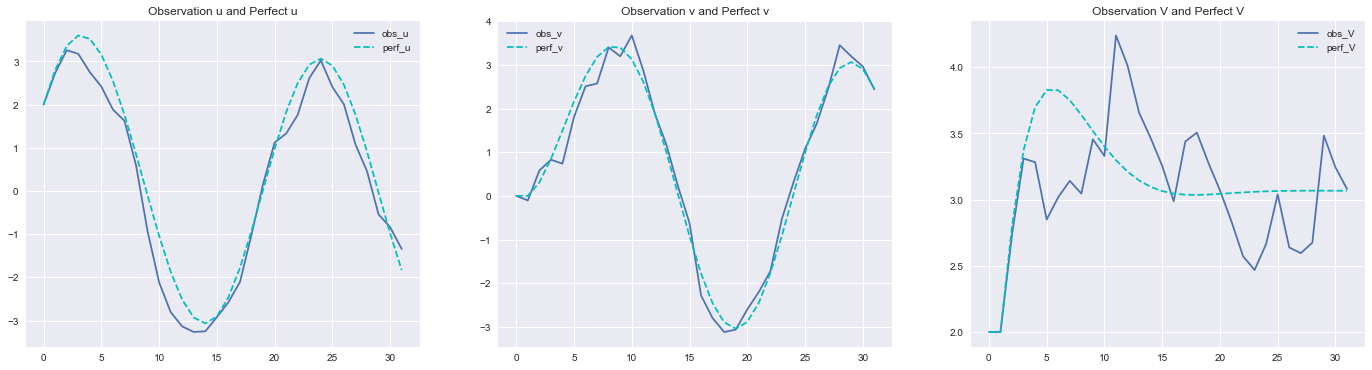

In [45]:
plt.figure(figsize = (24, 6))
plt.subplot(1, 3, 1)
plt.plot(obs_u, label = 'obs_u')
plt.plot(perf_u, linestyle = '--', color = 'c', label = 'perf_u')
plt.title("Observation u and Perfect u")
plt.legend(loc = 'best')

plt.subplot(1, 3, 2)
plt.plot(obs_v, label = 'obs_v')
plt.plot(perf_v, linestyle = '--', color = 'c', label = 'perf_v')
plt.title("Observation v and Perfect v")
plt.legend(loc = 'best')

plt.subplot(1, 3, 3)
plt.plot(obs_V, label = 'obs_V')
plt.plot(perf_V, linestyle = '--', color = 'c', label = 'perf_V')
plt.title("Observation V and Perfect V")
plt.legend(loc = 'best')
plt.show()

In [47]:
# combine observation
y = np.c_[obs_u, obs_v, obs_V]
y.shape

(32, 3)

In [72]:
am = Adjoint_Method(y, n_epoch, n_dim_sys, n_dim_obs, initial_x, x_background, 
                 background_covariance, observation_covariance,
                 model_update_function = Euler_forward_differential, adjoint_update_function = adjoint_update_function,
                 forcing_wx = forcing_wx, forcing_wy = forcing_wy, f = f, dt = dt, alpha = alpha)
am.simulate()

 epoch : 100 / 100

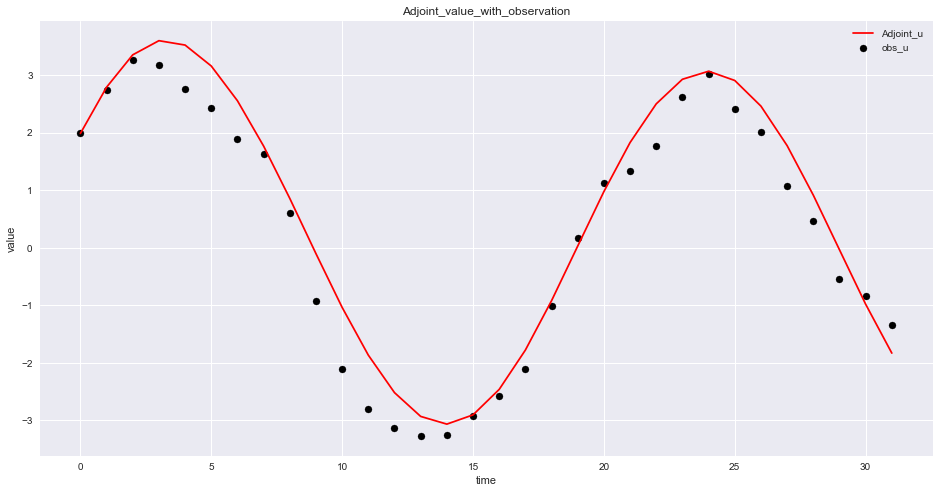

In [73]:
L = len(y)

plt.figure(figsize=(16,8))
plt.scatter(range(L), obs_u, color = "k", marker = 'o', label = "obs_u")
plt.plot(am.get_adjoint_value(0), color = "r", label = "Adjoint_u")
plt.legend(loc = 'best')
plt.xlabel('time')
plt.ylabel('value')
plt.title("Adjoint_value_with_observation")
plt.savefig("../plot/171203_adjoint_method_u.png")
plt.show()

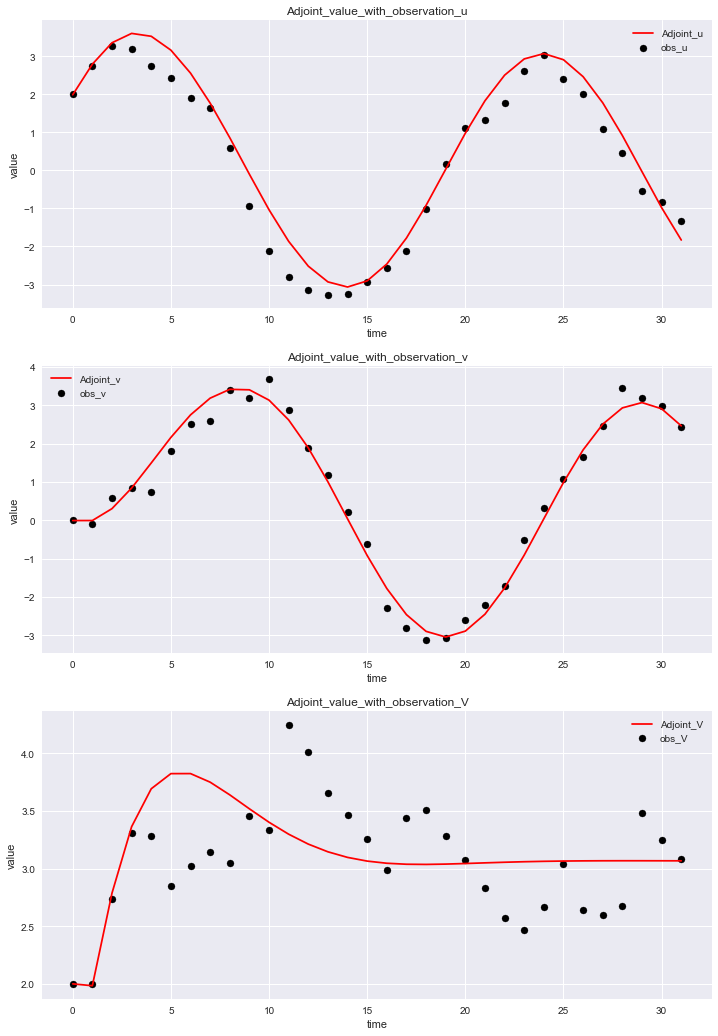

In [76]:
L = len(y)

plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
plt.scatter(range(L), obs_u, color = "k", marker = 'o', label = "obs_u")
plt.plot(am.get_adjoint_value(0), color = "r", label = "Adjoint_u")
plt.legend(loc = 'best')
plt.xlabel('time')
plt.ylabel('value')
plt.title("Adjoint_value_with_observation_u")

plt.subplot(3, 1, 2)
plt.scatter(range(L), obs_v, color = "k", marker = 'o', label = "obs_v")
plt.plot(am.get_adjoint_value(1), color = "r", label = "Adjoint_v")
plt.legend(loc = 'best')
plt.xlabel('time')
plt.ylabel('value')
plt.title("Adjoint_value_with_observation_v")

plt.subplot(3, 1, 3)
plt.scatter(range(L), obs_V, color = "k", marker = 'o', label = "obs_V")
plt.plot(am.get_adjoint_value(2), color = "r", label = "Adjoint_V")
plt.legend(loc = 'best')
plt.xlabel('time')
plt.ylabel('value')
plt.title("Adjoint_value_with_observation_V")

plt.savefig("../plot/171203_adjoint_method_epoch" + str(n_epoch) + ".png")
plt.show()

今日のポジティブ
- アジョイント法実装できた！（多分）
- 最適な$x_0$になってそう！